# Single XGBoost - Add "Selected" Features

In this notebook, I train a model using the most effective features identified in [this notebook](https://www.kaggle.com/code/masayakawamata/xgb-forward-feature-selection) with forward feature selection.

The feature ideas are based on techniques shared by Chris Deotte in his first-place solutions:

**References:**  
- https://www.kaggle.com/code/cdeotte/first-place-single-model-lb-38-81
- https://www.kaggle.com/code/cdeotte/first-place-single-model-cv-1-016-lb-1-016

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 100)

TARGET = 'Listening_Time_minutes'
CATS = ['Podcast_Name', 'Episode_Num', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
NUMS = ['Episode_Length_minutes', 'Host_Popularity_percentage', 
        'Guest_Popularity_percentage', 'Number_of_Ads']

oof_pred_name = '2+3+4_interact_xgb'

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
train = pd.read_csv('../data/raw/train.csv', index_col='id')
test = pd.read_csv('../data/raw/test.csv', index_col='id')
original = pd.read_csv('../data/raw/podcast_dataset.csv')
print(f"Train shape: {train.shape}")
print(f"Test  shape: {test.shape}")
print(f"Orig  shape: {original.shape}")
train.head(3)

Train shape: (750000, 11)
Test  shape: (250000, 10)
Orig  shape: (52500, 11)


,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
id,,,,,,,,,,,
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,Joke Junction,Episode 26,119.8,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.9,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531


In [4]:
original_clean = original.dropna(subset=[TARGET]).drop_duplicates()
train = pd.concat([train, original_clean], axis=0, ignore_index=True)

# Add Features

In [5]:
def feature_eng(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # df['Episode_Num'] = df['Episode_Title'].str[8:]     
    # df['is_weekend']   = df['Publication_Day'].isin(['Saturday', 'Sunday']).astype(int)

    return df.drop(columns=['Episode_Title'])

train = feature_eng(train)
test = feature_eng(test)

In [6]:
# ELM = []
# for k in range(3):
#     col_name = f'ELm_r{k}'
#     train[col_name] = train['Episode_Length_minutes'].round(k)
#     test[col_name] = test['Episode_Length_minutes'].round(k)
#     ELM.append(col_name)

In [7]:
encoded_columns = []

selected_comb = [
    # 2-interaction
    ['Episode_Length_minutes', 'Host_Popularity_percentage'],
    ['Episode_Length_minutes', 'Guest_Popularity_percentage'],
    ['Episode_Length_minutes', 'Number_of_Ads'],
    ['Episode_Num', 'Host_Popularity_percentage'],
    ['Episode_Num', 'Guest_Popularity_percentage'],
    ['Episode_Num', 'Number_of_Ads'],    
    ['Host_Popularity_percentage', 'Guest_Popularity_percentage'],
    ['Host_Popularity_percentage', 'Number_of_Ads'],
    ['Host_Popularity_percentage', 'Episode_Sentiment'],
    ['Episode_Length_minutes', 'Podcast_Name'],
    ['Episode_Num', 'Podcast_Name'],  
    ['Guest_Popularity_percentage', 'Podcast_Name'],
    
# #     # 3-interaction
#     ['Episode_Length_minutes', 'Episode_Num', 'Host_Popularity_percentage'],
#     ['Episode_Length_minutes', 'Episode_Num', 'Guest_Popularity_percentage'],
#     ['Episode_Length_minutes', 'Episode_Num', 'Number_of_Ads'],
#     ['Episode_Length_minutes', 'Episode_Num', 'Episode_Sentiment'],
#     ['Episode_Length_minutes', 'Episode_Num', 'Publication_Day'],
#     ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage'],
#     ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Number_of_Ads'],
#     ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Episode_Sentiment'],
#     ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Publication_Day'],
#     ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Publication_Time'],
#     ['Episode_Length_minutes', 'Guest_Popularity_percentage', 'Number_of_Ads'],
#     ['Episode_Length_minutes', 'Guest_Popularity_percentage', 'Publication_Day'],
#     ['Episode_Length_minutes', 'Guest_Popularity_percentage', 'Publication_Time'],
#     ['Episode_Length_minutes', 'Number_of_Ads', 'Episode_Sentiment'],
#     ['Episode_Length_minutes', 'Number_of_Ads', 'Publication_Day'],
#     ['Episode_Length_minutes', 'Episode_Sentiment', 'Publication_Time'],
#     ['Episode_Num', 'Host_Popularity_percentage', 'Guest_Popularity_percentage'],
#     ['Episode_Num', 'Host_Popularity_percentage', 'Number_of_Ads'],
#     ['Episode_Num', 'Host_Popularity_percentage', 'Episode_Sentiment'],
#     ['Episode_Num', 'Host_Popularity_percentage', 'Publication_Day'],
#     ['Episode_Num', 'Host_Popularity_percentage', 'Publication_Time'],
#     ['Episode_Num', 'Host_Popularity_percentage', 'Genre'],
#     ['Episode_Num', 'Guest_Popularity_percentage', 'Number_of_Ads'],
#     ['Episode_Num', 'Guest_Popularity_percentage', 'Episode_Sentiment'],
#     ['Episode_Num', 'Guest_Popularity_percentage', 'Publication_Day'],
#     ['Episode_Num', 'Guest_Popularity_percentage', 'Publication_Time'],
#     ['Episode_Num', 'Guest_Popularity_percentage', 'Genre'],
#     ['Episode_Num', 'Number_of_Ads', 'Episode_Sentiment'],
#     ['Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads'],
#     ['Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Episode_Sentiment'],
#     ['Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Publication_Day'],
#     ['Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Publication_Time'],
#     ['Host_Popularity_percentage', 'Number_of_Ads', 'Publication_Day'],

#     ['Guest_Popularity_percentage', 'Number_of_Ads', 'Episode_Sentiment'],
#     ['Guest_Popularity_percentage', 'Number_of_Ads', 'Genre'],    
    
#     # 4-interaction
#     ['Episode_Length_minutes', 'Episode_Num', 'Host_Popularity_percentage', 'Guest_Popularity_percentage'],
#     ['Episode_Length_minutes', 'Episode_Num', 'Host_Popularity_percentage', 'Number_of_Ads'],
#     ['Episode_Length_minutes', 'Episode_Num', 'Host_Popularity_percentage', 'Episode_Sentiment'],
#     ['Episode_Length_minutes', 'Episode_Num', 'Host_Popularity_percentage', 'Publication_Day'],
#     ['Episode_Length_minutes', 'Episode_Num', 'Host_Popularity_percentage', 'Publication_Time'],
#     ['Episode_Length_minutes', 'Episode_Num', 'Host_Popularity_percentage', 'Genre'],
#     ['Episode_Length_minutes', 'Episode_Num', 'Guest_Popularity_percentage', 'Number_of_Ads'],
#     ['Episode_Length_minutes', 'Episode_Num', 'Guest_Popularity_percentage', 'Episode_Sentiment'],
#     ['Episode_Length_minutes', 'Episode_Num', 'Guest_Popularity_percentage', 'Publication_Day'],
#     ['Episode_Length_minutes', 'Episode_Num', 'Guest_Popularity_percentage', 'Publication_Time'],
#     ['Episode_Length_minutes', 'Episode_Num', 'Number_of_Ads', 'Episode_Sentiment'],
#     ['Episode_Length_minutes', 'Episode_Num', 'Number_of_Ads', 'Publication_Day'],
#     ['Episode_Length_minutes', 'Episode_Num', 'Number_of_Ads', 'Publication_Time'],
#     ['Episode_Length_minutes', 'Episode_Num', 'Publication_Day', 'Publication_Time'],
#     ['Episode_Length_minutes', 'Episode_Num', 'Publication_Day', 'Genre'],    
#     ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads'],
#     ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Episode_Sentiment'],
#     ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Publication_Day'],
#     ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Publication_Time'],
#     ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Number_of_Ads', 'Episode_Sentiment'],
#     ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Number_of_Ads', 'Publication_Day'],
#     ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Publication_Day', 'Publication_Time'],
#     ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Publication_Day', 'Genre'],
#     ['Episode_Length_minutes', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Episode_Sentiment'],
#     ['Episode_Length_minutes', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Publication_Day'],
#     ['Episode_Length_minutes', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Publication_Time'],
#     ['Episode_Length_minutes', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Genre'],
#     ['Episode_Length_minutes', 'Episode_Num', 'Publication_Time', 'Podcast_Name'],
    
#     ['Episode_Num', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads'],
#     ['Episode_Num', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Episode_Sentiment'],
#     ['Episode_Num', 'Host_Popularity_percentage', 'Number_of_Ads', 'Publication_Day'],
#     ['Episode_Num', 'Host_Popularity_percentage', 'Number_of_Ads', 'Publication_Time'],
#     ['Episode_Num', 'Host_Popularity_percentage', 'Episode_Sentiment', 'Publication_Day'],
#     ['Episode_Num', 'Host_Popularity_percentage', 'Episode_Sentiment', 'Publication_Time'],
#     ['Episode_Num', 'Host_Popularity_percentage', 'Episode_Sentiment', 'Genre'],
#     ['Episode_Num', 'Host_Popularity_percentage', 'Publication_Day', 'Publication_Time'],
#     ['Episode_Num', 'Host_Popularity_percentage', 'Publication_Time', 'Genre'],
#     ['Episode_Num', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Episode_Sentiment'],
#     ['Episode_Num', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Genre'],
#     ['Episode_Num', 'Host_Popularity_percentage', 'Episode_Sentiment', 'Podcast_Name'],
#     ['Host_Popularity_percentage', 'Number_of_Ads', 'Episode_Sentiment', 'Podcast_Name'],
#     ['Host_Popularity_percentage', 'Number_of_Ads', 'Publication_Day', 'Podcast_Name'],
#     ['Host_Popularity_percentage', 'Number_of_Ads', 'Publication_Time', 'Podcast_Name'],
    
]

for comb in selected_comb:
    name = '_'.join(comb)
        
    if len(comb) == 2:
        train[name] = train[comb[0]].astype(str) + '_' + train[comb[1]].astype(str)
        test[name] = test[comb[0]].astype(str) + '_' + test[comb[1]].astype(str)
        
    elif len(comb) == 3:
        train[name] = (train[comb[0]].astype(str) + '_' +
                       train[comb[1]].astype(str) + '_' +
                       train[comb[2]].astype(str))
        test[name] = (test[comb[0]].astype(str) + '_' +
                      test[comb[1]].astype(str) + '_' +
                      test[comb[2]].astype(str))
        
    elif len(comb) == 4:
        train[name] = (train[comb[0]].astype(str) + '_' +
                       train[comb[1]].astype(str) + '_' +
                       train[comb[2]].astype(str) + '_' +
                       train[comb[3]].astype(str))
        test[name] = (test[comb[0]].astype(str) + '_' +
                      test[comb[1]].astype(str) + '_' +
                      test[comb[2]].astype(str) + '_' +
                      test[comb[3]].astype(str))
    
    encoded_columns.append(name)

train[encoded_columns] = train[encoded_columns].astype('category')
test[encoded_columns] = test[encoded_columns].astype('category')

KeyError: 'Episode_Num'

In [ ]:
# reference: https://www.kaggle.com/code/masayakawamata/imputation-strategies/
train[NUMS] = train[NUMS].fillna(train[NUMS].median())
test[NUMS] = test[NUMS].fillna(train[NUMS].median())

In [ ]:
FEATURES = NUMS + CATS + encoded_columns

print(f"Train Shape: {train.shape}")
print(f"Test  Shape: {test.shape}")
train.head(3)

Train Shape: (794868, 59)
Test  Shape: (250000, 58)


,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Episode_Num,is_weekend,Episode_Length_minutes_Host_Popularity_percentage,Episode_Length_minutes_Guest_Popularity_percentage,Episode_Length_minutes_Number_of_Ads,Episode_Num_Host_Popularity_percentage,Episode_Num_Guest_Popularity_percentage,Episode_Num_Number_of_Ads,Host_Popularity_percentage_Guest_Popularity_percentage,Host_Popularity_percentage_Number_of_Ads,Host_Popularity_percentage_Episode_Sentiment,Episode_Length_minutes_Podcast_Name,Episode_Num_Podcast_Name,Guest_Popularity_percentage_Podcast_Name,Episode_Length_minutes_Episode_Num_Host_Popularity_percentage,Episode_Length_minutes_Episode_Num_Guest_Popularity_percentage,Episode_Length_minutes_Episode_Num_Number_of_Ads,Episode_Length_minutes_Episode_Num_Episode_Sentiment,Episode_Length_minutes_Episode_Num_Publication_Day,Episode_Length_minutes_Host_Popularity_percentage_Guest_Popularity_percentage,Episode_Length_minutes_Host_Popularity_percentage_Number_of_Ads,Episode_Length_minutes_Host_Popularity_percentage_Episode_Sentiment,Episode_Length_minutes_Host_Popularity_percentage_Publication_Day,Episode_Length_minutes_Host_Popularity_percentage_Publication_Time,Episode_Length_minutes_Guest_Popularity_percentage_Number_of_Ads,Episode_Length_minutes_Guest_Popularity_percentage_Publication_Day,Episode_Length_minutes_Guest_Popularity_percentage_Publication_Time,Episode_Length_minutes_Number_of_Ads_Episode_Sentiment,Episode_Length_minutes_Number_of_Ads_Publication_Day,Episode_Length_minutes_Episode_Sentiment_Publication_Time,Episode_Num_Host_Popularity_percentage_Guest_Popularity_percentage,Episode_Num_Host_Popularity_percentage_Number_of_Ads,Episode_Num_Host_Popularity_percentage_Episode_Sentiment,Episode_Num_Host_Popularity_percentage_Publication_Day,Episode_Num_Host_Popularity_percentage_Publication_Time,Episode_Num_Host_Popularity_percentage_Genre,Episode_Num_Guest_Popularity_percentage_Number_of_Ads,Episode_Num_Guest_Popularity_percentage_Episode_Sentiment,Episode_Num_Guest_Popularity_percentage_Publication_Day,Episode_Num_Guest_Popularity_percentage_Publication_Time,Episode_Num_Guest_Popularity_percentage_Genre,Episode_Num_Number_of_Ads_Episode_Sentiment,Host_Popularity_percentage_Guest_Popularity_percentage_Number_of_Ads,Host_Popularity_percentage_Guest_Popularity_percentage_Episode_Sentiment,Host_Popularity_percentage_Guest_Popularity_percentage_Publication_Day,Host_Popularity_percentage_Guest_Popularity_percentage_Publication_Time,Host_Popularity_percentage_Number_of_Ads_Publication_Day,Guest_Popularity_percentage_Number_of_Ads_Episode_Sentiment,Guest_Popularity_percentage_Number_of_Ads_Genre
0,Mystery Matters,63.77,True Crime,74.81,Thursday,Night,53.36,0.0,Positive,31.41998,98,0,nan_74.81,nan_nan,nan_0.0,98_74.81,98_nan,98_0.0,74.81_nan,74.81_0.0,74.81_Positive,nan_Mystery Matters,98_Mystery Matters,nan_Mystery Matters,nan_98_74.81,nan_98_nan,nan_98_0.0,nan_98_Positive,nan_98_Thursday,nan_74.81_nan,nan_74.81_0.0,nan_74.81_Positive,nan_74.81_Thursday,nan_74.81_Night,nan_nan_0.0,nan_nan_Thursday,nan_nan_Night,nan_0.0_Positive,nan_0.0_Thursday,nan_Positive_Night,98_74.81_nan,98_74.81_0.0,98_74.81_Positive,98_74.81_Thursday,98_74.81_Night,98_74.81_True Crime,98_nan_0.0,98_nan_Positive,98_nan_Thursday,98_nan_Night,98_nan_True Crime,98_0.0_Positive,74.81_nan_0.0,74.81_nan_Positive,74.81_nan_Thursday,74.81_nan_Night,74.81_0.0_Thursday,nan_0.0_Positive,nan_0.0_True Crime
1,Joke Junction,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,26,1,119.8_66.95,119.8_75.95,119.8_2.0,26_66.95,26_75.95,26_2.0,66.95_75.95,66.95_2.0,66.95_Negative,119.8_Joke Junction,26_Joke Junction,75.95_Joke Junction,119.8_26_66.95,119.8_26_75.95,119.8_26_2.0,119.8_26_Negative,119.8_26_Saturday,119.8_66.95_75.95,119.8_66.95_2.0,119.8_66.95_Negative,119.8_66.95_Saturday,119.8_66.95_Afternoon,119.8_75.95_2.0

# Train XGBoost

In [ ]:
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor
import gc

In [ ]:

def target_encode(df_train, df_val, col, target, stats='mean', prefix='TE'):
    df_val = df_val.copy()
    agg = df_train.groupby(col)[target].agg(stats)    
    if isinstance(stats, (list, tuple)):
        for s in stats:
            colname = f"{prefix}_{col}_{s}"
            df_val[colname] = df_val[col].map(agg[s]).astype(float)
            df_val[colname].fillna(agg[s].mean(), inplace=True)
    else:
        suffix = stats if isinstance(stats, str) else stats.__name__
        colname = f"{prefix}_{col}_{suffix}"
        df_val[colname] = df_val[col].map(agg).astype(float)
        df_val[colname].fillna(agg.mean(), inplace=True)
    return df_val

In [ ]:
# reference: https://www.kaggle.com/code/act18l/say-goodbye-to-ordinalencoder
class OrderedTargetEncoder(BaseEstimator, TransformerMixin):
    """
    Out‑of‑fold **mean‑rank** encoder with optional smoothing.
    • Encodes each category by the *rank* of its target mean within a fold.
    • Unseen categories get the global mean rank (or −1 if you prefer).
    """
    def __init__(self, cat_cols=None, n_splits=5, smoothing=0):
        self.cat_cols   = cat_cols
        self.n_splits   = n_splits
        self.smoothing  = smoothing       # 0 = no smoothing
        self.maps_      = {}              # per‑fold maps
        self.global_map = {}              # fit on full data for test set

    def _make_fold_map(self, X_col, y):
        means = y.groupby(X_col, dropna=False).mean()
        if self.smoothing > 0:
            counts = y.groupby(X_col, dropna=False).count()
            smooth = (counts * means + self.smoothing * y.mean()) / (counts + self.smoothing)
            means  = smooth
        return {k: r for r, k in enumerate(means.sort_values().index)}

    def fit(self, X, y):
        X, y = X.reset_index(drop=True), y.reset_index(drop=True)
        if self.cat_cols is None:
            self.cat_cols = X.select_dtypes(include='object').columns.tolist()

        kf = KFold(self.n_splits, shuffle=True, random_state=42)
        self.maps_ = {col: [None]*self.n_splits for col in self.cat_cols}

        for fold, (tr_idx, _) in enumerate(kf.split(X)):
            X_tr, y_tr = X.loc[tr_idx], y.loc[tr_idx]
            for col in self.cat_cols:
                self.maps_[col][fold] = self._make_fold_map(X_tr[col], y_tr)

        for col in self.cat_cols:
            self.global_map[col] = self._make_fold_map(X[col], y)

        return self

    def transform(self, X, y=None, fold=None):
        """
        • During CV pass fold index to use fold‑specific maps (leak‑free).
        • At inference time (fold=None) uses global map.
        """
        X = X.copy()
        tgt_maps = {col: (self.global_map[col] if fold is None else self.maps_[col][fold])
                    for col in self.cat_cols}
        for col, mapping in tgt_maps.items():
            X[col] = X[col].map(mapping).fillna(-1).astype(int)
        return X

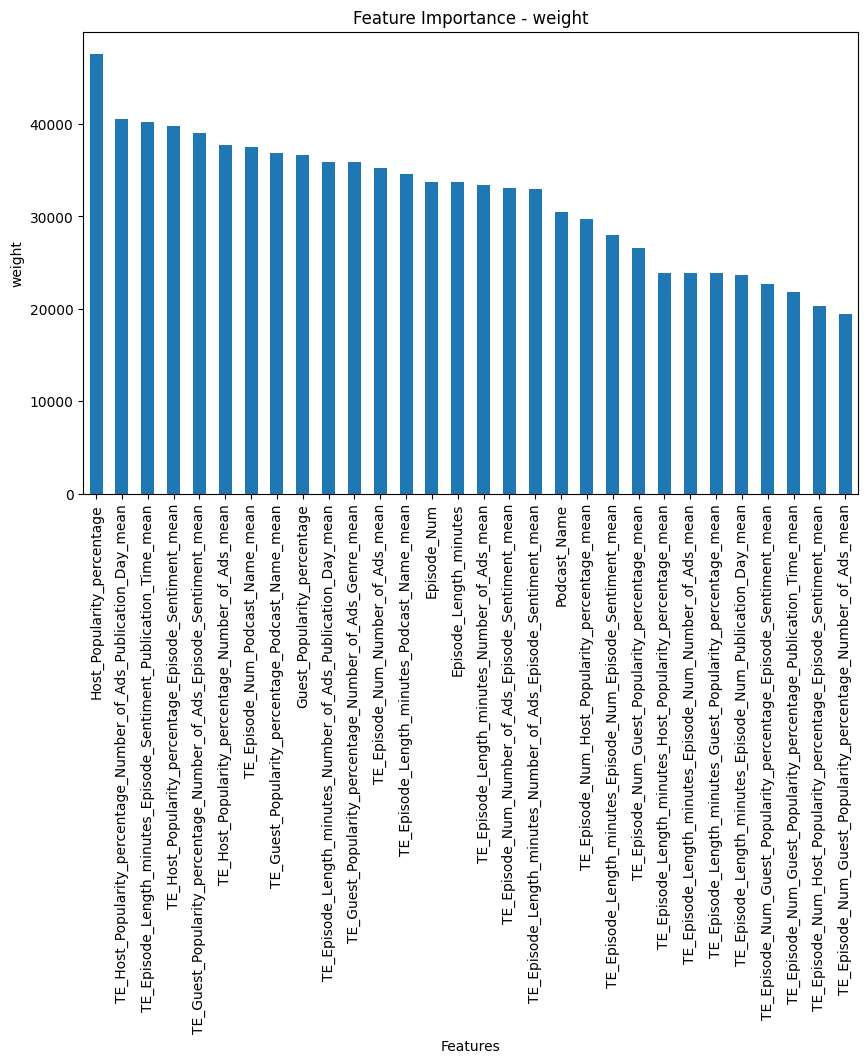

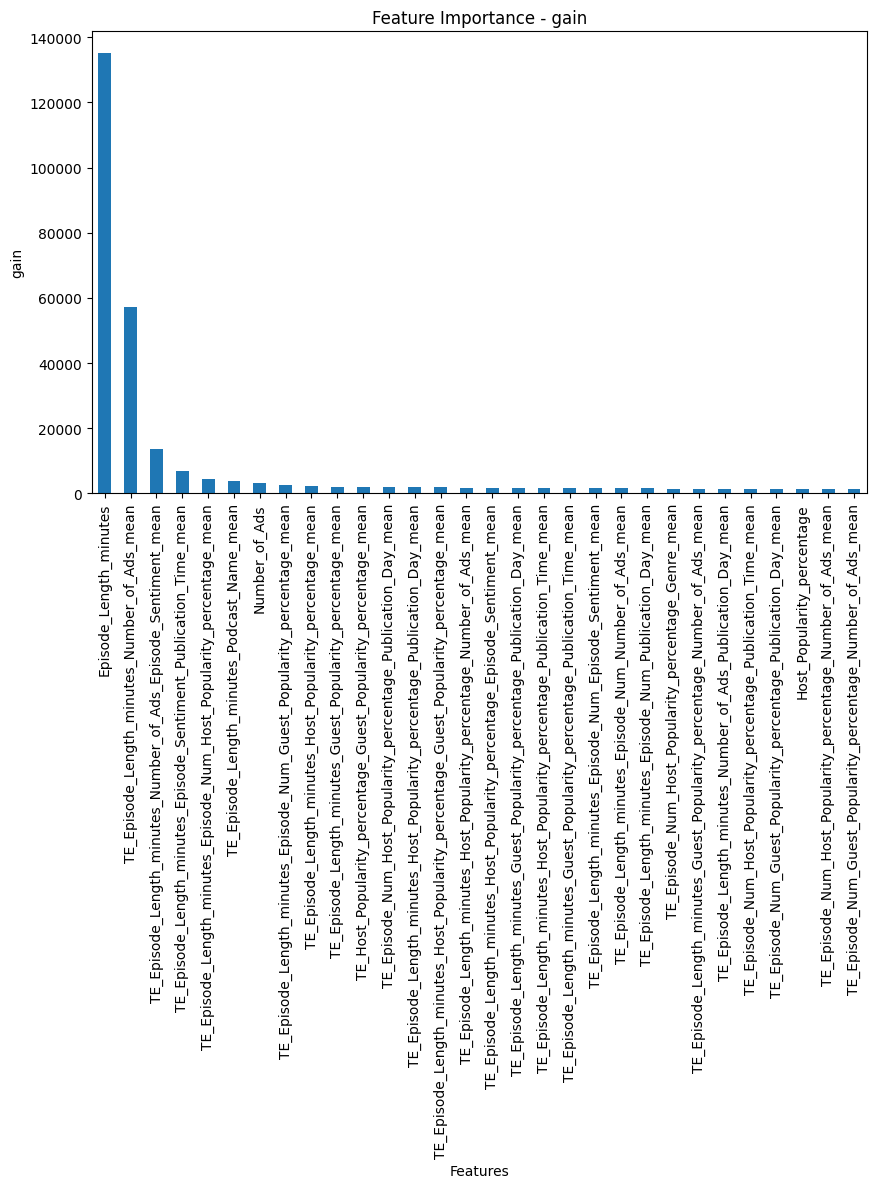

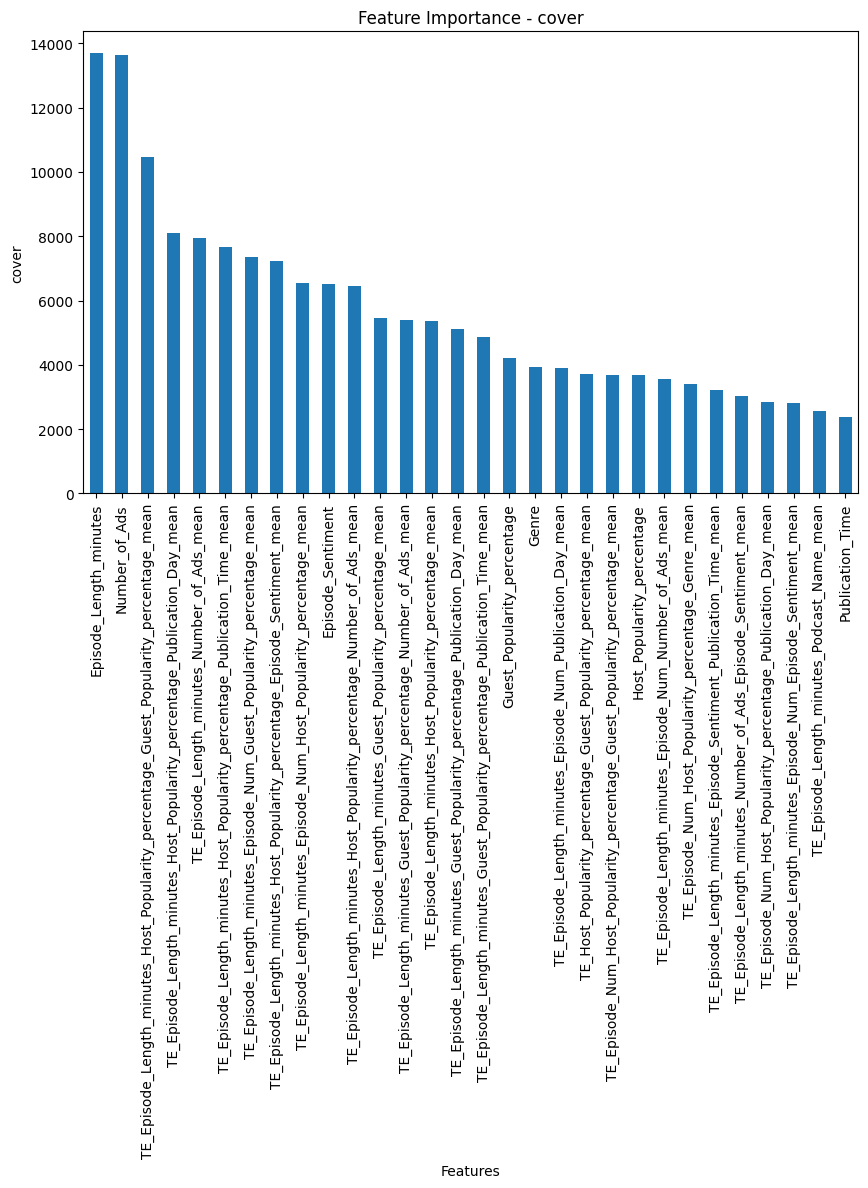

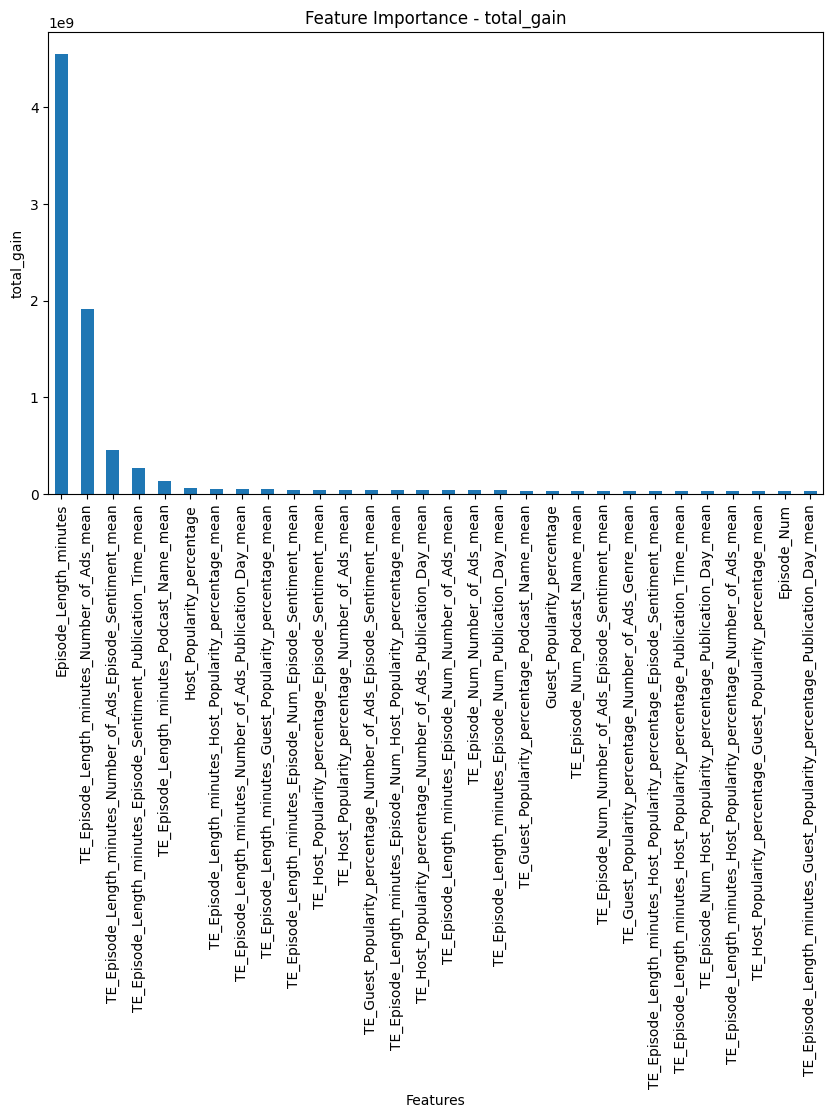

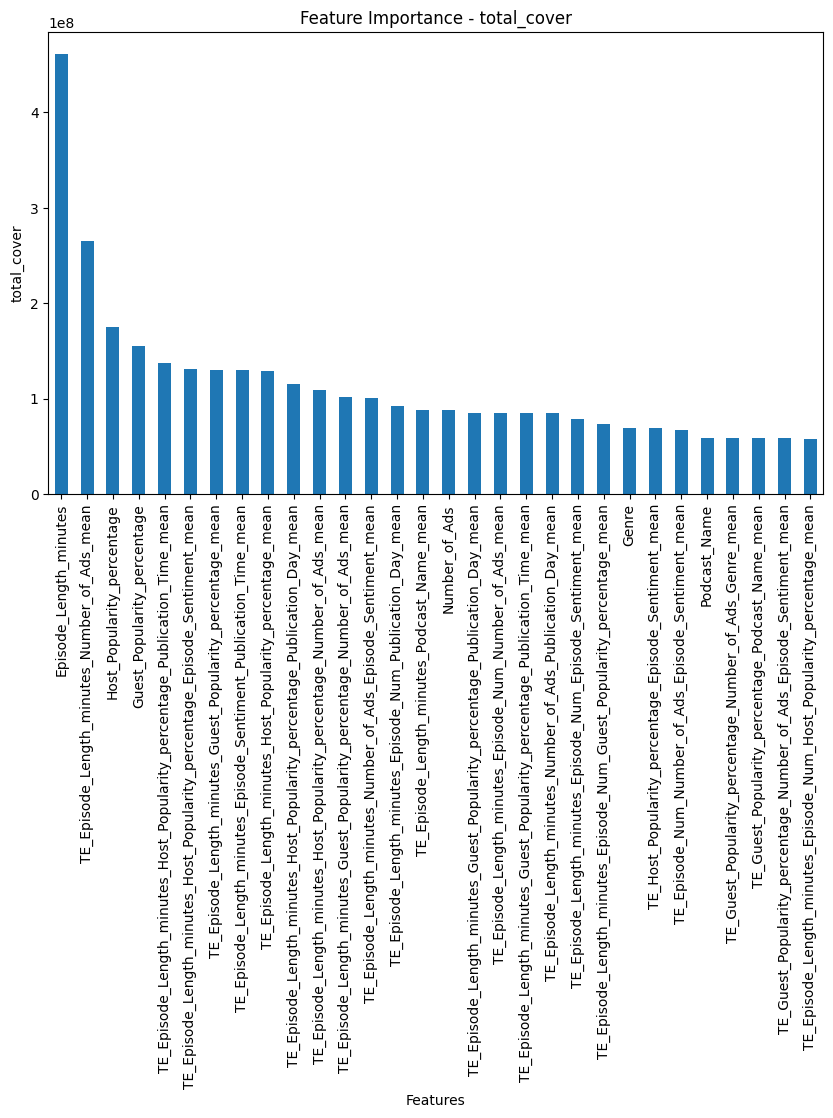

In [ ]:
importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

booster = model.get_booster()

for itype in importance_types:
    score = booster.get_score(importance_type=itype)
    score_series = pd.Series(score).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    score_series.head(30).plot(kind='bar')
    plt.title(f"Feature Importance - {itype}")
    plt.ylabel(itype)
    plt.xlabel("Features")
    plt.tight_layout()
    plt.show()

# Submission

In [ ]:
sub = pd.read_csv('/kaggle/input/playground-series-s5e4/sample_submission.csv')
sub[TARGET] = pred
sub.to_csv('submission.csv', index=False)
sub.head(3)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/playground-series-s5e4/sample_submission.csv'

In [ ]:
import pickle

data_to_save = {
    'oof': oof,
    'pred': pred,
}

with open(f'oof_pred_{oof_pred_name}.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)


# with open('oof_pred.pkl', 'rb') as f:
#     data = pickle.load(f)

# oof = data['oof']
# pred = data['pred']